# HappyDBで文書分類してみる（日本語篇）
〜英文データセットを日本語翻訳して文書分類してみる〜

## 概要

### HappyDBとは
- HappyDBは、リクルートのAI研究所 Megagon Labsが2017年に作成した、「幸せな瞬間」（"Happy Moment"）の記述文を集めたデータセット
- 言語は英語
- GitHub --> [megagonlabs/HappyDB](https://github.com/megagonlabs/HappyDB)
- Paper --> ["HappyDB: A Corpus of 100,000 Crowdsourced Happy Moments" (Asai, et al., 2018)](https://arxiv.org/pdf/1801.07746.pdf)

### やりたいこと
- 英語での文書分類を試した
    - [HappyDBで『幸せな瞬間』を文書分類してみる](https://qiita.com/izaki_shin/items/d817f544451bb4ba88dd)
- やはり日本語で文書分類を試してみたい
- 英文データセットを日本語翻訳してどの程度使えるものなのかを試してみる

### 注意点
- このnotebookでは、翻訳済みのデータを使用（翻訳にはDeepLを使用）

## 1. 環境構築

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# GiNZAのインストール
# cf. https://megagonlabs.github.io/ginza/

# 今回は、従来型モデル、を使用
! pip install -U ginza ja_ginza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. データの準備
GoogleDrive上の、HappyDB 日本語翻訳済みデータ を読み込む

In [3]:
# cf. https://blog.kikagaku.co.jp/google-colab-drive-mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
happydb_jp_file = 'drive/MyDrive/Colab Notebooks/Data/HappyDB/jp/happydb_jp.csv'

df_hm = pd.read_csv(happydb_jp_file)
df_hm.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,jp_text
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,NaN
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection,NaN
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise,NaN


In [5]:
# 前処理
# 1. 日本語訳が存在しないものは削除
# 2. 全く同じ文章は削除 (cf. https://note.nkmk.me/python-pandas-duplicated-drop-duplicates/)
df_hm_target = df_hm.dropna(subset=['jp_text'])
df_hm_target = df_hm_target.drop_duplicates(subset=['cleaned_hm'])

df_hm_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 3 to 100532
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   hmid                   6258 non-null   int64 
 1   wid                    6258 non-null   int64 
 2   reflection_period      6258 non-null   object
 3   original_hm            6258 non-null   object
 4   cleaned_hm             6258 non-null   object
 5   modified               6258 non-null   bool  
 6   num_sentence           6258 non-null   int64 
 7   ground_truth_category  6258 non-null   object
 8   predicted_category     6258 non-null   object
 9   jp_text                6258 non-null   object
dtypes: bool(1), int64(3), object(6)
memory usage: 495.0+ KB


In [6]:
# 英文, 日本語訳, ラベル の3セットをランダムに表示する
df_hm_target[['cleaned_hm', 'jp_text', 'ground_truth_category']].sample(n=10)

,cleaned_hm,jp_text,ground_truth_category
88941,"I arrived at a restaurant to eat dinner, reall...",チーズバーガーが食べたくて夕食を食べにレストランに着いたところ、ハンバーガーが半額になる日だ...,enjoy_the_moment
13589,Getting a big long happy hug from my two-year ...,2歳の孫に抱きしめてもらい、大満足。,affection
13876,My best friend and I went shopping and I found...,親友と買い物に行ったのですが、すごいお得な情報を見つけてしまいました。,bonding
26063,I felt very happy yesterday when I was talking...,昨日、旧友と話をしていて、とても幸せな気分になりました。,bonding
97284,I won a spin roller lucky draw today afternoon...,今日の午後、ショッピングモールに行ったら初めてスピンローラーラッキードローが当たって、とても...,achievement
7417,Ordering over 8 lbs of animal crackers and six...,30分前にAmazonで8ポンド以上の動物クラッカーと6ポンドのフロストポップタルトを注文し...,achievement
88413,Having a good day for sales at the store.,店頭での販売が好調な日。,achievement
17263,I got to celebrate my mom's surprise 70th birt...,母のサプライズ70歳の誕生日パーティーを家族でお祝いすることができました。,affection
25641,I got to watch the entire baseball game.,野球の試合は全部見れたよ。,leisure
23225,I listened to a new music album on the way to ...,通勤途中に新しい音楽アルバムを聴いたのですが、とても楽しめました。明日も聴くのが楽しみです。,enjoy_the_moment


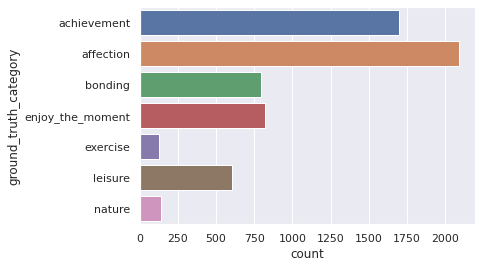

In [7]:
# ラベルの分布を描画
LABELS_ALL = sorted(df_hm_target.ground_truth_category.unique())
sns.countplot(y='ground_truth_category', data=df_hm_target, order=LABELS_ALL)

## 3. 原文（英語）で文書分類

In [8]:
# 入力データとラベルの準備
docs = df_hm_target['cleaned_hm'].tolist()
labels = df_hm_target['ground_truth_category'].tolist()
label_ids = np.array([LABELS_ALL.index(label) for label in labels])

#BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(min_df=0.0001, stop_words='english')
bow_vectorizer.fit(docs)
x_data = bow_vectorizer.transform(docs).toarray()

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 層化k分割交差検証
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scores_all = []
for train_index, test_index in skf.split(x_data, label_ids):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_true = label_ids[train_index], label_ids[test_index]

    # 学習
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    # クラス別のPrecision, Recall, F1-scoreを計算
    scores = []
    scores.append(precision_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(recall_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(f1_score(y_true=y_true, y_pred=y_pred, average=None))
    scores_all.append(scores)

# 各スコアの平均値を算出
scores_mean = np.stack(scores_all).mean(axis=0)
df_scores_mean = pd.DataFrame(scores_mean.T, index=LABELS_ALL, columns=['precision', 'recall', 'f1'])
df_scores_mean

,precision,recall,f1
achievement,0.731194,0.848278,0.785185
affection,0.908121,0.918068,0.913014
bonding,0.920873,0.829552,0.872543
enjoy_the_moment,0.559865,0.539615,0.549538
exercise,0.842637,0.464000,0.586830
leisure,0.656992,0.573939,0.610162
nature,0.809810,0.457407,0.574006


## 4. 日本語翻訳で文書分類

In [9]:
# GiNZAで分かち書きする
import spacy
nlp = spacy.load('ja_ginza')

def wakati_preprocess(text):
    """分かち書き. 各単語はlemma（原形）に変換しておく."""
    doc = nlp(text)
    lemmas = []
    for sent in doc.sents:
        for token in sent:
            lemmas.append(token.lemma_)
    return ' '.join(lemmas)

print(wakati_preprocess('すもももももももものうち。'))

すもも も もも も もも の うち 。


In [10]:
# 分かち書きを適用
docs_jp = [wakati_preprocess(text) for text in df_hm_target['jp_text'].tolist()]

In [11]:
# BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(max_df=0.5, min_df=0.001, stop_words=[])
bow_vectorizer.fit(docs_jp)

vocab = bow_vectorizer.get_feature_names_out().tolist()
print(len(vocab))
print(vocab)

1043
['10', '100', '12', '15', '18', '1日', '20', '200', '2017', '24', '25', '2人', '30', '40', '45', '50', '70', 'amazon', 'ebay', 'facebook', 'hit', 'mturk', 'netflix', 'youtube', 'あげる', 'あと', 'あなた', 'あまり', 'ありがとう', 'ある', 'いい', 'いう', 'いく', 'いくつ', 'いただく', 'いっぱい', 'いつも', 'いとこ', 'いる', 'いろいろ', 'うち', 'うまい', 'うれしい', 'おいしい', 'おかげ', 'おく', 'おしゃべり', 'おもちゃ', 'おやつ', 'おる', 'お客様', 'お店', 'お母さん', 'お気に入り', 'お礼', 'お祝い', 'お腹', 'お菓子', 'お金', 'かかる', 'かかわる', 'かける', 'かなり', 'から', 'かわいい', 'がる', 'きれい', 'くださる', 'くつろぐ', 'くらい', 'くる', 'くれる', 'ぐっすり', 'けど', 'ここ', 'こと', 'こなす', 'この', 'これ', 'こんな', 'ござる', 'ご飯', 'させる', 'さらに', 'さん', 'しか', 'しかし', 'しっかり', 'しばらく', 'しまう', 'しれる', 'じい', 'すぎる', 'すぐ', 'すごい', 'すでに', 'すべて', 'する', 'ずっと', 'せる', 'そう', 'そこ', 'そして', 'その', 'そば', 'それ', 'そんな', 'たい', 'たくさん', 'ただ', 'たち', 'ため', 'たり', 'だけ', 'だり', 'ちゃん', 'ちゃんと', 'ちょうど', 'ちょっと', 'ついに', 'つく', 'つける', 'つながる', 'つもり', 'てらっしゃる', 'てる', 'できる', 'です', 'とき', 'ところ', 'とても', 'とも', 'とる', 'どう', 'どこ', 'どの', 'どれ', 'どんな', 'ない', 'なかなか', 'ながら', 'なくなる', 'なし', 'なぜ', 'など

In [12]:
# ベクトル化
x_data = bow_vectorizer.transform(docs_jp).toarray()

In [13]:
# 後は英語版と同様

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 層化k分割交差検証
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scores_all = []
for train_index, test_index in skf.split(x_data, label_ids):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_true = label_ids[train_index], label_ids[test_index]

    # 学習
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    # クラス別のPrecision, Recall, F1-scoreを計算
    scores = []
    scores.append(precision_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(recall_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(f1_score(y_true=y_true, y_pred=y_pred, average=None))
    scores_all.append(scores)

# 各スコアの平均値を算出
scores_mean = np.stack(scores_all).mean(axis=0)
df_scores_mean = pd.DataFrame(scores_mean.T, index=LABELS_ALL, columns=['precision', 'recall', 'f1'])
df_scores_mean

,precision,recall,f1
achievement,0.682503,0.812861,0.741966
affection,0.792301,0.802104,0.797129
bonding,0.910081,0.826996,0.866432
enjoy_the_moment,0.541356,0.485905,0.511552
exercise,0.844899,0.488000,0.602425
leisure,0.632730,0.550675,0.587945
nature,0.768485,0.378307,0.494318


## 5. 訓練済みモデルでカテゴリ推定してみる

In [14]:
# 全サンプルで訓練し直す
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_data, label_ids)

LogisticRegression(max_iter=1000)

In [15]:
def classify_hm_category(text):
    text_wakati = wakati_preprocess(text)
    x = bow_vectorizer.transform([text_wakati]).toarray()
    pred_id = logreg.predict(x)[0]
    return LABELS_ALL[pred_id]

def try_hm_category_prediction(text):
    pred_cat = classify_hm_category(text)
    print('text :', text)
    print('category :', pred_cat)

In [16]:
try_hm_category_prediction('昼ごはんに食べたカニクリームコロッケが美味しすぎて感動した')

text : 昼ごはんに食べたカニクリームコロッケが美味しすぎて感動した
category : enjoy_the_moment


In [17]:
try_hm_category_prediction('読書の時間を持つことができたこと')

text : 読書の時間を持つことができたこと
category : leisure


In [18]:
try_hm_category_prediction('読書の時間を持てたこと')

text : 読書の時間を持てたこと
category : leisure


In [19]:
try_hm_category_prediction('今日は姪と遊んで楽しく過ごせた')

text : 今日は姪と遊んで楽しく過ごせた
category : affection


In [20]:
try_hm_category_prediction('昨日は友人と久々に電話をして話をした')

text : 昨日は友人と久々に電話をして話をした
category : bonding


In [21]:
try_hm_category_prediction('今朝はちゃんと起きてランニングをした')

text : 今朝はちゃんと起きてランニングをした
category : achievement


In [22]:
try_hm_category_prediction('今朝はちゃんと起きてヨガをした')

text : 今朝はちゃんと起きてヨガをした
category : exercise


In [23]:
try_hm_category_prediction('今日は久々に実家に帰ってきて両親とゆっくり夕ご飯を食べた')

text : 今日は久々に実家に帰ってきて両親とゆっくり夕ご飯を食べた
category : affection
